# Phase1_Project

### Objective : To provide to Microsoft Studio information on the kinds of movies that are doing well at the box office

###  Data Source

I made use of the im.db dataset and the bm.gross.movie.csv file for our analysis

### Getting Started - How success is defined

I defined success of a movie based on the revenue generated by a movie. Of course, there are other metrics that can define success, but from a business perspective, since the aim of any business is to be profitable, I only considered the total gross amount.

In [1]:
# Importing relevant libraries for our analysis

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

# creating a connection to the im.db database which serves as the data source
conn = sqlite3.connect('im.db')

## Getting a feel for the data

In [2]:
# initial look at the different tables
# converting all the tables into a df using the dataframe constructor 

movie_basics = pd.DataFrame(pd.read_sql('SELECT * FROM movie_basics',conn))
movie_basics.head()


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [3]:
movie_ratings = pd.DataFrame(pd.read_sql('SELECT * FROM movie_ratings',conn))
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [4]:
movie_akas = pd.DataFrame(pd.read_sql('SELECT * FROM movie_akas',conn))
movie_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [5]:
# Getting an idea of the size of the tables

print('Shape of movie_basics table :',movie_basics.shape)
print('Shape of movie_ratings table :',movie_ratings.shape)
print('Shape of movie_akas table : ',movie_akas.shape)


Shape of movie_basics table : (146144, 6)
Shape of movie_ratings table : (73856, 3)
Shape of movie_akas table :  (331703, 8)


## Cleaning up data - movie_basics table

> From the shapes of the tables, it is evident that there is a ***disparity in the amount of data between the tables.*** 

> I started my analysis by looking at the **movie_basics** table first

In [6]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


> **original_title, runtime_minutes and genres have missing values.**
 Getting an idea of the amount of missing data:

In [7]:
print('Number of rows missing in the original_title column :',len(movie_basics[movie_basics['original_title'].isna()]))
print('Number of rows missing in the runtime_miutes column :',len(movie_basics[movie_basics['runtime_minutes'].isna()]))
print('Number of rows missing in the genres column :',len(movie_basics[movie_basics['genres'].isna()]))


Number of rows missing in the original_title column : 21
Number of rows missing in the runtime_miutes column : 31739
Number of rows missing in the genres column : 5408


> Since the missing data in the **'original_title' is < 1%**, I deleted the rows with missing data


In [8]:
# using .dropna to remove rows with NaN values in the 'original_title' columns

movie_basics.dropna(subset=['original_title'], inplace = True)

In [9]:
# check to the see the if the numbers have changed

movie_basics.info()

# can see the number of rows have reduced from 146144 to 146123

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


> Since we will not be examining the runtime_minutes for our analysis, we can remove the column from the dataset.

In [10]:
# deleting the runtime column

movie_basics.drop('runtime_minutes', axis=1, inplace = True)
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          140734 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> Next,examining the **genres** column:

In [11]:
movie_basics['genres'].isna().value_counts()

False    140734
True       5389
Name: genres, dtype: int64

> It looks like genres column has **5389 missing values**. Checking the different values of the genres column

In [12]:
movie_basics['genres'].value_counts()

Documentary                 32185
Drama                       21486
Comedy                       9177
Horror                       4372
Comedy,Drama                 3519
                            ...  
Adventure,Romance,Sport         1
Horror,Talk-Show                1
Biography,Mystery,Sci-Fi        1
Animation,Horror,Sci-Fi         1
Adult,Horror                    1
Name: genres, Length: 1085, dtype: int64

> We can see that the values are varied(1085). Also, **some movies are classified under 2-3 genres** making it difficult to predict what the missing genres might be. 

> Since the amount of missing data for the genres is also quite large i.e 5389 rows, filling in missing values with guesswork can skew the analysis in any number of ways. So the best way would be to just classify the data as **'missing'**

In [13]:
# filling the missing data with 'missing'
movie_basics['genres'].fillna('missing',inplace = True)

In [14]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   movie_id        146123 non-null  object
 1   primary_title   146123 non-null  object
 2   original_title  146123 non-null  object
 3   start_year      146123 non-null  int64 
 4   genres          146123 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.7+ MB


> The **movie_basics** table has now **no missing values**

> Next, since the **bom.movie_gross.csv** table has the gross amounts for each movie, I created a new df titled **movie_gross** to use in my analysis

In [15]:
# converting the movie_gross table into a dataframe
movie_gross = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


## Creating a new dataframe for analysis - movie_gross

>  **combining movie_basics and the movie_gross tables** to get information on how much money each movie has made:

In [16]:
# using the merge method to combine the movie_basics and the movie_gross df's
# using the inner merge will give us only movie_titles that have gross amounts listed.
# any other merge method will result in a lot of redundant data

movie_gross_df = movie_basics.merge(movie_gross, how = 'inner', left_on = 'primary_title', right_on = 'title')
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,NaN,2016
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000,2012
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000,2012
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000,2012
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000,2012


> To look at **total_gross**, need to sum **domestic_gross** and **foreign_gross**. Since, foreign_gross is listed as an **object data type**, I had to convert it into **float64** to be able to compute the sum

In [17]:
# removing the ',' from the string
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','') 

# converting 'foreign_gross' to float datatype
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].astype('float64')


In [18]:
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3342 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


## Filling in missing data - movie_gross

In [19]:
print(movie_gross_df['domestic_gross'].isna().value_counts())
print(movie_gross_df['foreign_gross'].isna().value_counts())

False    3342
True       24
Name: domestic_gross, dtype: int64
False    2043
True     1323
Name: foreign_gross, dtype: int64


> Getting some stats of the domestic_gross column to see if I can **impute values**:

In [20]:
# create a function to compute the stats
# just the pass the series name as an argument into the function

def stats(column):
    
    mean_value = round(column.mean())
    median_value = round(column.median())
    std_dev = round(column.std())
    
    return mean_value, median_value,std_dev       

In [21]:
stat_values = stats(movie_gross_df['domestic_gross'])
stat_values

(29865597.0, 1950000.0, 65323288.0)

> I imputed **median value** for the missing data in the **domestic_gross** column and re-computed the stats to see if there was any discernible change

In [22]:
# Imputing the median value
movie_gross_df['domestic_gross'] = movie_gross_df['domestic_gross'].fillna(stat_values[1])

In [23]:
# checking to see if any missing data 
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   2043 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


> We can see that the domestic_gross has no more null values

In [24]:
# re-computing the stats
new_stat_values = stats(movie_gross_df['domestic_gross'])
new_stat_values

(29666555.0, 1950000.0, 65132297.0)

In [25]:
# Calculating percentage change:

mean_change = ((new_stat_values[0]-stat_values[0])/stat_values[0]) * 100
median_change = ((new_stat_values[1]-stat_values[1])/stat_values[1]) * 100
std_dev_change = ((new_stat_values[2]-stat_values[2])/stat_values[2]) * 100

print(mean_change, "", median_change, "", std_dev_change)

-0.6664591369126155  0.0  -0.2923781178926572


> Since there is **less than 1% change** by imputing the median value, I decided to keep this 
  Next, looking at the foreign gross column

In [26]:
movie_gross_df['foreign_gross'].isna().value_counts()

False    2043
True     1323
Name: foreign_gross, dtype: int64

> Since there are **1323 empty values**, I need to calcuate the stats of the foreign_gross column to see what values I can use to impute.

In [27]:
# compute the stats using the stats function defined earlier
fd_stats = stats(movie_gross_df['foreign_gross'])
fd_stats

(74551466.0, 19600000.0, 134783459.0)

> Note about the data : the stats for the foreign gross cannot be considered to be wholly accurate due to large volume of missing data ( ~ 40%). But, this is what I have to work with. I can always exclude the foreign_gross column later, if need be.

In [28]:
#imputing the median value
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].fillna(fd_stats[1])

In [29]:
# check the table
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        3366 non-null   object 
 1   primary_title   3366 non-null   object 
 2   original_title  3366 non-null   object 
 3   start_year      3366 non-null   int64  
 4   genres          3366 non-null   object 
 5   title           3366 non-null   object 
 6   studio          3363 non-null   object 
 7   domestic_gross  3366 non-null   float64
 8   foreign_gross   3366 non-null   float64
 9   year            3366 non-null   int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 289.3+ KB


> Adding a new column: **total_gross** to see how much each movie grossed totally: domestic + overseas

In [30]:
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']

In [31]:
# check to see if the total_gross column is created
movie_gross_df.head()

,movie_id,primary_title,original_title,start_year,genres,title,studio,domestic_gross,foreign_gross,year,total_gross
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,19600000.0,2016,20700000.0
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012,8744000.0
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000.0,2012,8744000.0
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000.0,2012,8744000.0


## Question 1

> #### Grouping by genres and plotting against total_gross to see how much each genre has grossed

In [32]:
# creating a new df and using groupby to get total_gross by genres type
df_genres = movie_gross_df.groupby(['genres']).sum()
df_genres.reset_index(inplace = True)
df_genres.head()

,genres,start_year,domestic_gross,foreign_gross,year,total_gross
0,Action,44303,3.477635e+08,9.252000e+08,44318,1.272963e+09
1,"Action,Adventure",12076,3.245000e+05,8.244700e+07,12080,8.277150e+07
2,"Action,Adventure,Animation",44311,2.184660e+09,4.367500e+09,44318,6.552160e+09
3,"Action,Adventure,Biography",8062,2.402290e+08,5.881000e+08,8063,8.283290e+08
4,"Action,Adventure,Comedy",64493,3.172472e+09,6.631400e+09,64499,9.803872e+09


In [33]:
# sorting the total_gross column in descending order to get the highest grossing genres
df_genres.sort_values(by=['total_gross'], ascending = False, inplace = True, ignore_index=True)
df_genres.head()

,genres,start_year,domestic_gross,foreign_gross,year,total_gross
0,"Adventure,Animation,Comedy",151065,9.645133e+09,1.802100e+10,151076,2.766613e+10
1,"Action,Adventure,Sci-Fi",94658,1.102470e+10,1.663100e+10,94662,2.765570e+10
2,Drama,789516,4.611663e+09,9.435122e+09,789549,1.404679e+10
3,"Action,Adventure,Fantasy",62467,4.378787e+09,8.936100e+09,62470,1.331489e+10
4,"Action,Adventure,Comedy",64493,3.172472e+09,6.631400e+09,64499,9.803872e+09


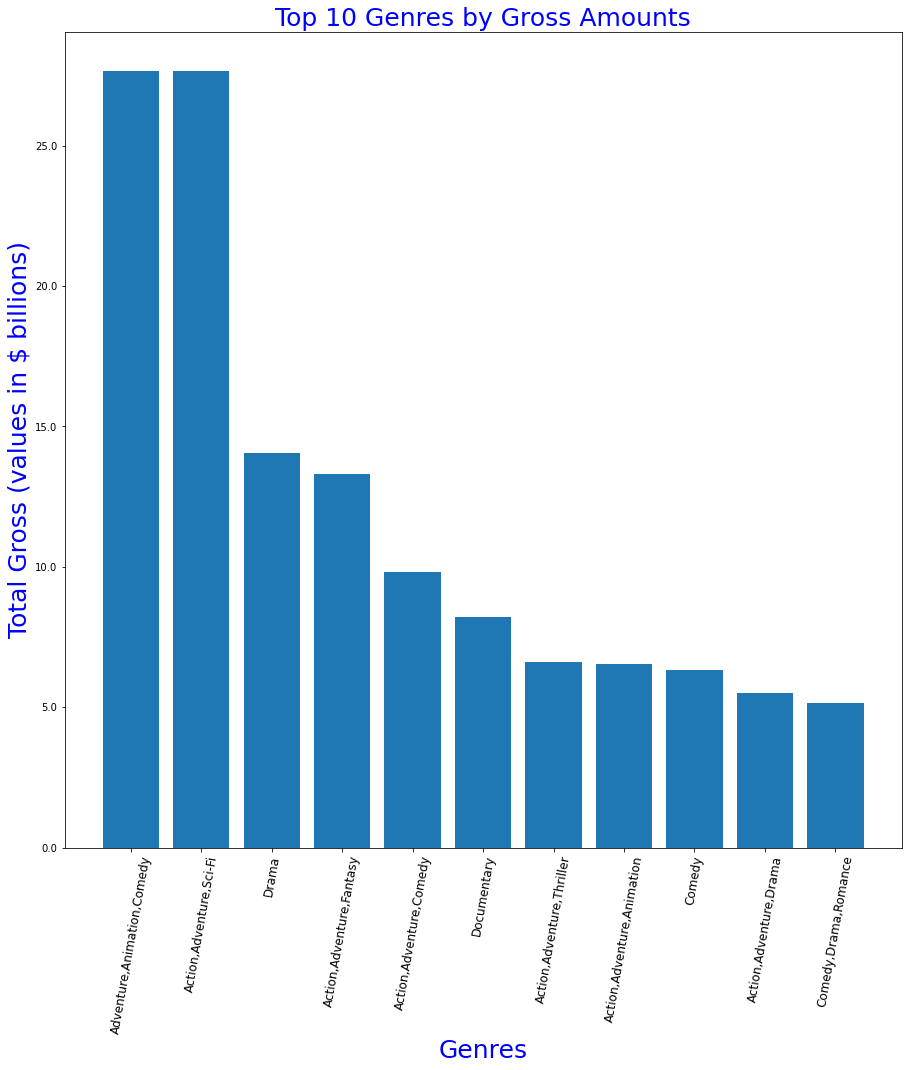

In [34]:
# creating a plot to look at the top 10 genres that have grossed the most

def billions_formatter(x,pos):
    return  f'{x/1000000000}'

fig,ax = plt.subplots(figsize = (15,15))

ax.bar(x=df_genres.loc[0:10, 'genres'], height=df_genres.loc[0:10, 'total_gross'], width=0.8) # specifying only the first 10 rows
ax.tick_params(axis = 'x', labelsize = 12, labelrotation = 80) # formatting the x axis labels
ax.ticklabel_format(axis = 'y', style = 'plain') # supressing scientific notation on the Y-axis
# ax.yaxis.set_major_formatter('${x:1.2f}')
ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax.set_title('Top 10 Genres by Gross Amounts', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax.set_xlabel('Genres', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax.set_ylabel('Total Gross (values in $ billions)', fontdict = {'fontsize' : 25, 'color' :'blue'})

plt.show()

## Question 2

In [35]:
# creating a new df and removing duplicate movie_id's 
movie_akas2 = movie_akas.drop_duplicates(subset = ['movie_id'], keep = 'first', ignore_index = True)
movie_akas2.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0381957,1,Cloud Cuckoo Land,GB,None,None,None,0.0
2,tt0401729,10,Джон Картер: Мiж двох свiтiв,UA,None,None,None,0.0
3,tt10010134,1,Versailles Rediscovered - The Sun King's Vanis...,None,None,original,None,1.0
4,tt10027708,1,Miguelito - Canto a Borinquen,None,None,original,None,1.0


In [36]:
# Let's join the movie_basics and movie_akas2 table 
movie_markets = movie_basics.merge(movie_akas2, how = 'inner', on = 'movie_id')
movie_markets.head()

,movie_id,primary_title,original_title,start_year,genres,ordering,title,region,language,types,attributes,is_original_title
0,tt0063540,Sunghursh,Sunghursh,2013,"Action,Crime,Drama",1,Sangharsh,IN,hi,None,alternative transliteration,0.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,"Biography,Drama",1,One Day Before the Rainy Season,XWW,en,None,None,0.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,Drama,10,La otra cara del viento,VE,None,None,None,0.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,"Comedy,Drama",1,Subse Bada Sukh,IN,bn,None,None,0.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,"Comedy,Drama,Fantasy",1,La Telenovela Errante,None,None,original,None,1.0


In [37]:
# checking to see if there are any duplicate values in movie_id's
movie_markets['movie_id'].duplicated().value_counts()

False    122300
Name: movie_id, dtype: int64

In [38]:
# merging the movie_gross_df and the movie_markets df's 
movie_markets_gross = movie_gross_df.merge(movie_markets, how = 'inner', on ='movie_id')
movie_markets_gross.head()

,movie_id,primary_title_x,original_title_x,start_year_x,genres_x,title_x,studio,domestic_gross,foreign_gross,year,...,original_title_y,start_year_y,genres_y,ordering,title_y,region,language,types,attributes,is_original_title
0,tt0315642,Wazir,Wazir,2016,"Action,Crime,Drama",Wazir,Relbig.,1100000.0,19600000.0,2016,...,Wazir,2016,"Action,Crime,Drama",1,Wazir,None,None,original,None,1.0
1,tt0337692,On the Road,On the Road,2012,"Adventure,Drama,Romance",On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2012,"Adventure,Drama,Romance",10,En el camino,AR,None,imdbDisplay,None,0.0
2,tt2404548,On the Road,On the Road,2011,Drama,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2011,Drama,1,On the Road,AM,None,None,None,0.0
3,tt3872966,On the Road,On the Road,2013,Documentary,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2013,Documentary,1,On the Road,DE,None,None,None,0.0
4,tt4339118,On the Road,On the Road,2014,Drama,On the Road,IFC,744000.0,8000000.0,2012,...,On the Road,2014,Drama,1,Wo zai lu shang zui ai ni,CN,cmn,imdbDisplay,None,0.0


> #### Grouping by markets and plotting against total_gross to see how much each market has grossed

In [39]:
# creating a new df by grouping markets

df_markets = movie_markets_gross.groupby(['region']).sum()
df_markets.reset_index(inplace = True)
df_markets.head()

,region,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,AL,2010,2.590000e+07,6.700000e+06,2010,3.260000e+07,2010,10,0.0
1,AM,2011,7.440000e+05,8.000000e+06,2012,8.744000e+06,2011,1,0.0
2,AR,114754,2.436009e+09,3.049356e+09,114769,5.485365e+09,114754,516,0.0
3,AT,16115,7.253020e+07,4.051000e+08,16113,4.776302e+08,16115,53,0.0
4,AU,40278,4.080374e+08,8.655000e+08,40269,1.273537e+09,40278,74,0.0


In [40]:
# sorting total_gross in descending order
df_markets.sort_values(by = ['total_gross'], ascending = False, inplace = True, ignore_index = True)
df_markets.head()

,region,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,US,690752,1.035034e+10,1.661247e+10,690813,2.696282e+10,690752,1090,0.0
1,RS,132910,3.764871e+09,7.003512e+09,132932,1.076838e+10,132910,624,0.0
2,UA,104719,3.830018e+09,5.819570e+09,104724,9.649588e+09,104719,484,0.0
3,BR,235642,3.614321e+09,5.709875e+09,235658,9.324196e+09,235642,927,0.0
4,IT,149033,3.567004e+09,5.757067e+09,149044,9.324071e+09,149033,677,0.0


In [41]:
# sorting total_gross in descending order
df_markets.sort_values(by = ['total_gross'], ascending = False, inplace = True, ignore_index = True)
df_markets.head()

,region,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,US,690752,1.035034e+10,1.661247e+10,690813,2.696282e+10,690752,1090,0.0
1,RS,132910,3.764871e+09,7.003512e+09,132932,1.076838e+10,132910,624,0.0
2,UA,104719,3.830018e+09,5.819570e+09,104724,9.649588e+09,104719,484,0.0
3,BR,235642,3.614321e+09,5.709875e+09,235658,9.324196e+09,235642,927,0.0
4,IT,149033,3.567004e+09,5.757067e+09,149044,9.324071e+09,149033,677,0.0


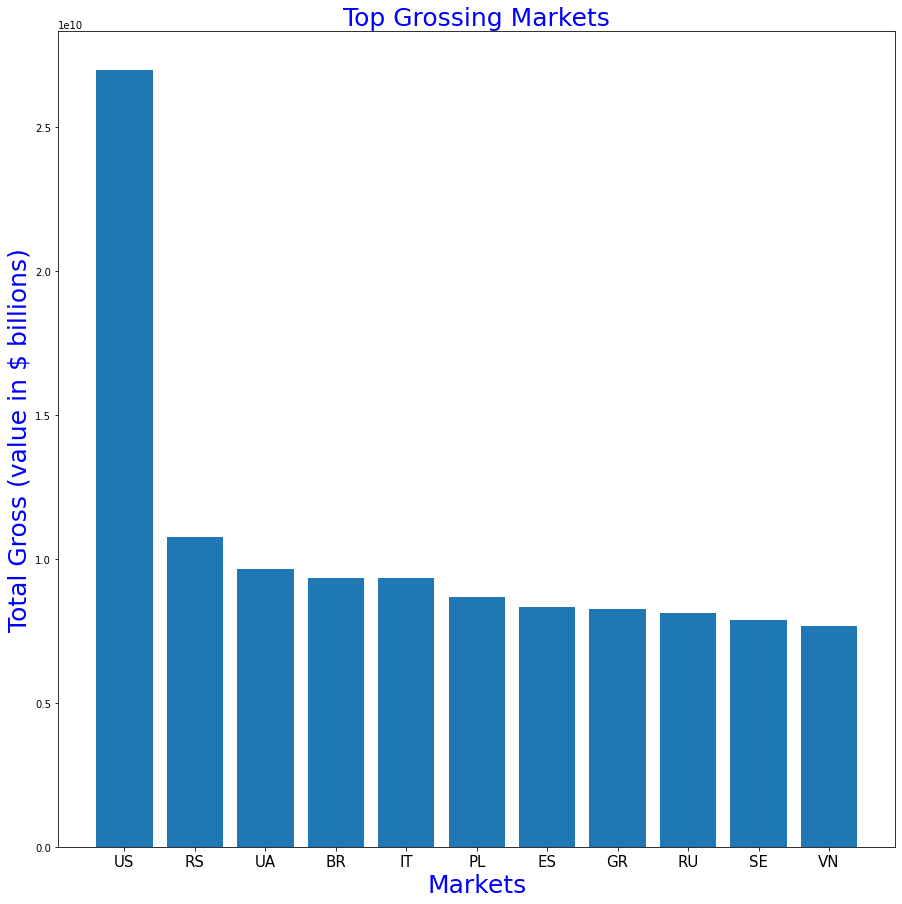

In [42]:
# plotting the markets vs total_gross to see which markets generate the most revenue


fig1, ax1 = plt.subplots(figsize = (15,15))

ax1.bar(x = df_markets.loc[:10, 'region'], height = df_markets.loc[:10, 'total_gross'])# specifying only the first 10 rows
ax1.tick_params(axis = 'x', labelsize = 15)# formatting the x axis labels
ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax1.set_title('Top Grossing Markets', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax1.set_xlabel('Markets', fontdict = {'fontsize' : 25, 'color' :'blue'} )
ax1.set_ylabel('Total Gross (value in $ billions)', fontdict = {'fontsize' : 25, 'color' :'blue'})
plt.show()

> From the analysis so far,we have gained the following insights :
  - The top grossing genre overall i.e. including all regions is 'Adventure,Animation,Comedy'
  - The top grossing market is the USA

## Question 3

> ### Analyzing the US market by genre

In [43]:
# creating a new slice of from the movie_markets_gross df by filtering out only the US market
us_market = movie_markets_gross.loc[movie_markets_gross['region'] == 'US']
us_market.head()

,movie_id,primary_title_x,original_title_x,start_year_x,genres_x,title_x,studio,domestic_gross,foreign_gross,year,...,original_title_y,start_year_y,genres_y,ordering,title_y,region,language,types,attributes,is_original_title
10,tt0372538,Spy,Spy,2011,"Action,Crime,Drama",Spy,Fox,110800000.0,124800000.0,2015,...,Spy,2011,"Action,Crime,Drama",1,Spy: The Movie,US,None,working,None,0.0
18,tt0402887,Capture the Flag,Capture the Flag,2010,Drama,Capture the Flag,Par.,6700.0,24600000.0,2015,...,Capture the Flag,2010,Drama,1,Capture the Flag,US,None,None,None,0.0
22,tt0419692,Disconnect,Disconnect,2010,"Drama,Mystery,Sci-Fi",Disconnect,LD,1400000.0,19600000.0,2013,...,Disconnect,2010,"Drama,Mystery,Sci-Fi",1,Disconnect,US,None,None,None,0.0
38,tt4028068,Wonder Woman,Wonder Woman,2014,Sci-Fi,Wonder Woman,WB,412600000.0,409300000.0,2017,...,Wonder Woman,2014,Sci-Fi,1,Wonder Woman,US,None,None,None,0.0
58,tt2951338,Unstoppable,Unstoppable,2015,"Biography,Documentary,History",Unstoppable,Fox,81600000.0,86200000.0,2010,...,Unstoppable,2015,"Biography,Documentary,History",1,Unstoppable,US,None,None,None,0.0


In [44]:
#checking to see if there are any duplicate movie_id's
us_market.duplicated(subset = ['movie_id']).sum()

0

In [45]:
# creating a new df and using group by to get the total_gross amounts by genres
us_market_genres =us_market.groupby(['genres_x']).sum()
us_market_genres.reset_index(inplace = True)
us_market_genres.head()

,genres_x,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,Action,6033,171600000.0,133000000.0,6048,304600000.0,6033,3,0.0
1,"Action,Adventure,Animation",2013,187200000.0,400000000.0,2013,587200000.0,2013,10,0.0
2,"Action,Adventure,Comedy",8067,4972800.0,813200000.0,8069,818172800.0,8067,31,0.0
3,"Action,Adventure,Crime",2018,6100000.0,19600000.0,2018,25700000.0,2018,10,0.0
4,"Action,Adventure,Drama",4029,49904200.0,20089000.0,4029,69993200.0,4029,11,0.0


In [46]:
# sorting by the total_gross in descending order 
us_market_genres.sort_values(by = ['total_gross'], ascending = False, inplace = True, ignore_index = True)
us_market_genres

,genres_x,start_year_x,domestic_gross,foreign_gross,year,total_gross,start_year_y,ordering,is_original_title
0,Drama,124856,1.444754e+09,2.310895e+09,124849,3.755649e+09,124856,107,0.0
1,"Action,Adventure,Sci-Fi",8060,9.480000e+08,2.051700e+09,8060,2.999700e+09,8060,40,0.0
2,Documentary,56384,5.370563e+08,8.642324e+08,56395,1.401289e+09,56384,28,0.0
3,Comedy,48324,6.606406e+08,7.151000e+08,48336,1.375741e+09,48324,96,0.0
4,Horror,22156,5.144916e+08,6.364000e+08,22157,1.150892e+09,22156,11,0.0
...,...,...,...,...,...,...,...,...,...
101,"Family,Sport",2019,1.840000e+05,2.400000e+06,2010,2.584000e+06,2019,1,0.0
102,"Documentary,History,News",2010,1.020000e+05,2.400000e+06,2013,2.502000e+06,2010,1,0.0
103,Fantasy,2012,1.460000e+05,1.400000e+06,2012,1.546000e+06,2012,1,0.0
104,"Biography,Drama,War",2018,7.250000e+05,2.290000e+05,2018,9.540000e+05,2018,1,0.0


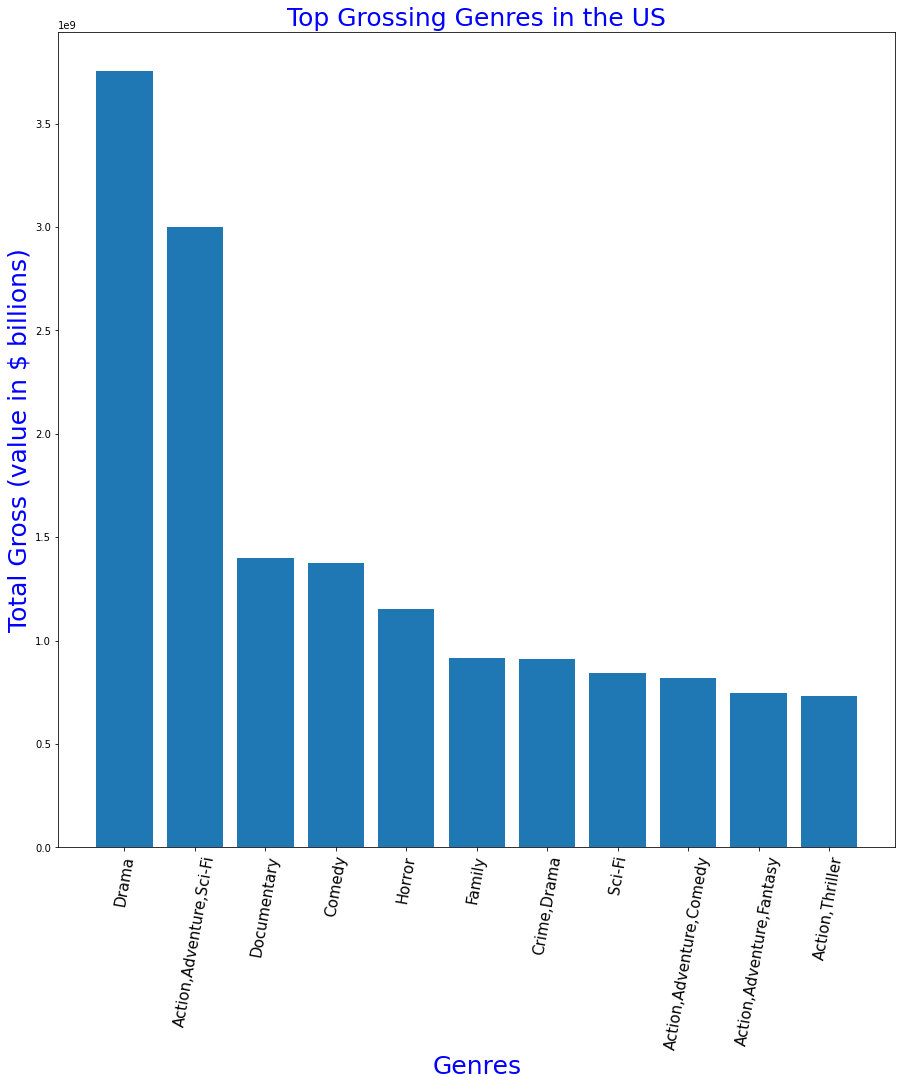

In [47]:
fig2, ax2 = plt.subplots(figsize = (15,15))

ax2.bar(x = us_market_genres.loc[:10, 'genres_x'], height = us_market_genres.loc[:10, 'total_gross'])
ax2.tick_params(axis = 'x', labelsize = 15, labelrotation = 80)
ax.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
ax2.set_title('Top Grossing Genres in the US', fontdict = {'fontsize' : 25, 'color' :'blue'})
ax2.set_xlabel('Genres', fontdict = {'fontsize' : 25, 'color' :'blue'} )
ax2.set_ylabel('Total Gross (value in $ billions)', fontdict = {'fontsize' : 25, 'color' :'blue'})
plt.show()

## Conclusion

By figuring out the largest market and the genres of movies that are most successful in the same, I can recommend to Microsoft Studio to focus on making movies that belong the 'Drama' genre catared to the US market.